In [1]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns
import matplotlib.gridspec as gridspec

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)
directory_search_pattern = "careless_runs/" #directory in which to search for tabular outputs. 

In [2]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.MLPL  = run_param.MLPL.astype( 'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

### Run scripts to calculate merging statistics

In [27]:
!pwd

/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme


In [28]:
%%bash

sh ./scripts/1_HEWL_anom_unfriedelize.sh

-1.00000


In [34]:
%%bash

sh ./scripts/2_HEWL_anom_refine.sh

Submitted batch job 21281646
Submitted batch job 21281650
Submitted batch job 21281651
Submitted batch job 21281653
Submitted batch job 21281655
Submitted batch job 21281656
Submitted batch job 21281657
Submitted batch job 21281658
Submitted batch job 21281659
Submitted batch job 21281660
Submitted batch job 21281661
Submitted batch job 21281662
Submitted batch job 21281663
Submitted batch job 21281664
Submitted batch job 21281666


In [38]:
%%bash

sh ./scripts/3_HEWL_anom_peak_heights.sh

In [71]:
%%bash

sh ./scripts/run_ccs.sh merge_HEWL_dw_mlp32_PEF_*

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_12172279_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_12172279_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.50000_0999_dmin1.73_12172373_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.50000_0999_dmin1.73_12172373_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.87500_0999_dmin1.73_12172593_poly
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/lysozyme/careless_runs/merge_HEWL_dw_mlp32_PEF_R0.87500_0999_dmin1.73_12172593_poly
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
/net/holy-nfsisilon

# Importing $CC_\text{pred}$

In [3]:
count=0
results_list=[]
params_list=[]
id_list=[]


for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
Read-in values of grid_id: 0.75000,  job_id: 12172443
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly
Read-in values of grid_id: 0.99805,  job_id: 12173055
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
Read-in values of grid_id: 0.96875,  job_id: 12172775
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
Read-in values of grid_id: 0.93750,  job_id: 12172665
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly
Read-in values of grid_id: 0.98438,  job_id: 12172866
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
Read-in values of grid_id: 0.99990,  job_id: 12173327
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly
Read-in values of grid_id: 0.99951,  job_id: 12173182
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly
Read-i

### Importing $CC_\text{1/2}$

In [4]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('cchalf_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'cchalf_overall.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        
        results_list.append(tmp)
all_results_cchalf=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
Read-in values of grid_id: 0.75000,  job_id: 12172443
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly
Read-in values of grid_id: 0.99805,  job_id: 12173055
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
Read-in values of grid_id: 0.96875,  job_id: 12172775
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
Read-in values of grid_id: 0.93750,  job_id: 12172665
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly
Read-in values of grid_id: 0.98438,  job_id: 12172866
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
Read-in values of grid_id: 0.99990,  job_id: 12173327
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly
Read-in values of grid_id: 0.99951,  job_id: 12173182
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly
Read-i

### Importing $CC_\text{anom}$

In [5]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccanom_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccanom_overall.csv'))
        
        try:
            print(dirpath)
            tmp_id=dirpath.split('_')[-5][1:]
            if tmp_id=="neg1":
                tmp_id = -1
            job_id=int(dirpath.split('_')[-2]) # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-5])
            
        tmp["grid_id"]=float(tmp_id)
        tmp["job_id"]=job_id
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id}")
        
        results_list.append(tmp)
all_results_ccanom=pd.concat(results_list)

./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_12172443_poly
Read-in values of grid_id: 0.75000,  job_id: 12172443
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_12173055_poly
Read-in values of grid_id: 0.99805,  job_id: 12173055
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.96875_0999_dmin1.73_12172775_poly
Read-in values of grid_id: 0.96875,  job_id: 12172775
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.93750_0999_dmin1.73_12172665_poly
Read-in values of grid_id: 0.93750,  job_id: 12172665
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.98438_0999_dmin1.73_12172866_poly
Read-in values of grid_id: 0.98438,  job_id: 12172866
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99990_0999_dmin1.73_12173327_poly
Read-in values of grid_id: 0.99990,  job_id: 12173327
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99951_0999_dmin1.73_12173182_poly
Read-in values of grid_id: 0.99951,  job_id: 12173182
./careless_runs/merge_HEWL_dw_mlp32_PEF_R0.99976_0999_dmin1.73_12173255_poly
Read-i

### Importing anomalous peak heights

In [6]:
all_results_peak_heights=pd.read_csv("HEWL_anom_peak_heights.csv").rename(columns={"frames":"grid_id"})

In [7]:
all_results_peak_heights["grid_id"]=all_results_peak_heights["grid_id"].round(5)

In [8]:
all_params.reset_index(drop=True,inplace=True)
#all_params.info()
all_params.head(10)

,MLPL,IL,PEF,PE-keys,DMIN,ITER,SEED,DW_list,rDW,STDOF,RU,grid_id,job_id
0,10,0,4,"xcal,ycal,BATCH",1.73,30000,18440,"None,0",0.75000,64.0,0,0.75000,12172443
1,10,0,4,"xcal,ycal,BATCH",1.73,30000,31737,"None,0",0.99805,64.0,0,0.99805,12173055
2,10,0,4,"xcal,ycal,BATCH",1.73,30000,29514,"None,0",0.96875,64.0,0,0.96875,12172775
3,10,0,4,"xcal,ycal,BATCH",1.73,30000,1968,"None,0",0.93750,64.0,0,0.93750,12172665
4,10,0,4,"xcal,ycal,BATCH",1.73,30000,11006,"None,0",0.98438,64.0,0,0.98438,12172866
5,10,0,4,"xcal,ycal,BATCH",1.73,30000,1384,"None,0",0.99990,64.0,0,0.99990,12173327
6,10,0,4,"xcal,ycal,BATCH",1.73,30000,5629,"None,0",0.99951,64.0,0,0.99951,12173182
7,10,0,4,"xcal,ycal,BATCH",1.73,30000,15755,"None,0",0.99976,64.0,0,0.99976,12173255
8,10,0,4,"xcal,ycal,BATCH",1.73,30000,3007,"None,0",0.99219,64.0,0,0.99219,12172949
9,10,0,4,"xcal,ycal,BATCH",1.73,30000,27443,"None,0",0.00000,64.0,0,0.00000,12172279


In [9]:
all_results_ccpred.head()

,Unnamed: 0,file,Resolution Range (Å),bin,test,Spacegroup,CCpred,grid_id,job_id
0,0,HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_predi...,55.38 - 1.73,0,Train,P 43 21 2,0.870253,0.75000,12172443
1,1,HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_predi...,55.38 - 1.73,0,Test,P 43 21 2,0.869916,0.75000,12172443
2,2,HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_predi...,55.38 - 1.73,0,Train,P 43 21 2,0.867146,0.75000,12172443
3,3,HEWL_dw_mlp32_PEF_R0.75000_0999_dmin1.73_predi...,55.38 - 1.73,0,Test,P 43 21 2,0.865256,0.75000,12172443
0,0,HEWL_dw_mlp32_PEF_R0.99805_0999_dmin1.73_predi...,55.38 - 1.73,0,Train,P 43 21 2,0.869540,0.99805,12173055


In [10]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [11]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["delay"] = [name[-5] for name in all_results_ccpred.file]
all_results_ccpred["delay"]=all_results_ccpred["delay"].astype('int32')
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results_ccpred.head()

test
index                   30
file                    30
grid_id                 30
job_id                  30
Resolution Range (Å)    30
CCpred_test             30
CCpred_train            30
delay                   30
dtype: int64


test,index,file,grid_id,job_id,Resolution Range (Å),CCpred_test,CCpred_train,delay
0,0,HEWL_dw_mlp32_PEF_R-1.00000_0999_dmin1.73_pred...,-1.0,12173405,55.38 - 1.73,0.867970,0.870025,0
1,1,HEWL_dw_mlp32_PEF_R-1.00000_0999_dmin1.73_pred...,-1.0,12173405,55.38 - 1.73,0.863514,0.866671,1
2,2,HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_predi...,0.0,12172279,55.38 - 1.73,0.867695,0.869835,0
3,3,HEWL_dw_mlp32_PEF_R0.00000_0999_dmin1.73_predi...,0.0,12172279,55.38 - 1.73,0.865290,0.866288,1
4,4,HEWL_dw_mlp32_PEF_R0.50000_0999_dmin1.73_predi...,0.5,12172373,55.38 - 1.73,0.866942,0.869791,0


In [12]:
all_results_ccpred = all_results_ccpred[["grid_id","job_id","CCpred_test","CCpred_train"]].groupby(by="job_id").mean().reset_index(drop=True)
all_results_ccpred["grid_id"]=all_results_ccpred["grid_id"].round(5)

### Clean `cchalf`,`ccanom`, and `peak heights` tables for `pandas` merging

In [13]:
all_results = all_results_ccpred.merge(all_results_peak_heights,on="grid_id")

In [14]:
all_results_ccanom1 = all_results_ccanom[["CCanom","grid_id","job_id","bin"]]
all_results_ccanom1 = all_results_ccanom1.groupby(by=["job_id"]).agg(CCanom=("CCanom","mean"),CCanom_std=("CCanom","std"),grid_id=("grid_id","first")).reset_index(drop=True)
all_results_ccanom1["grid_id"]=all_results_ccanom1["grid_id"].round(5)

In [15]:
all_results_cchalf1 = all_results_cchalf[["CChalf","grid_id","job_id","bin"]]
all_results_cchalf1 = all_results_cchalf1.groupby(by=["job_id"]).agg(CChalf=("CChalf","mean"),CChalf_std=("CChalf","std"),grid_id=("grid_id","first")).reset_index(drop=True)
all_results_cchalf1["grid_id"]=all_results_cchalf1["grid_id"].round(5)


In [16]:
all_results = all_results.merge(all_results_ccanom1,on="grid_id")
all_results = all_results.merge(all_results_cchalf1,on="grid_id")
all_results = all_results.rename(columns={"grid_id":"rDW"})

In [17]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rDW           15 non-null     float64
 1   CCpred_test   15 non-null     float64
 2   CCpred_train  15 non-null     float64
 3   CYS 6         15 non-null     float64
 4   MET 12        15 non-null     float64
 5   CYS 30        15 non-null     float64
 6   CYS 64        15 non-null     float64
 7   CYS 76        15 non-null     float64
 8   CYS 80        15 non-null     float64
 9   CYS 94        15 non-null     float64
 10  MET 105       15 non-null     float64
 11  CYS 115       15 non-null     float64
 12  CYS 127       15 non-null     float64
 13  IOD 2         15 non-null     float64
 14  IOD 3         15 non-null     float64
 15  IOD 4         15 non-null     float64
 16  IOD 5         15 non-null     float64
 17  IOD 6         15 non-null     float64
 18  CCanom        15 non-null     fl

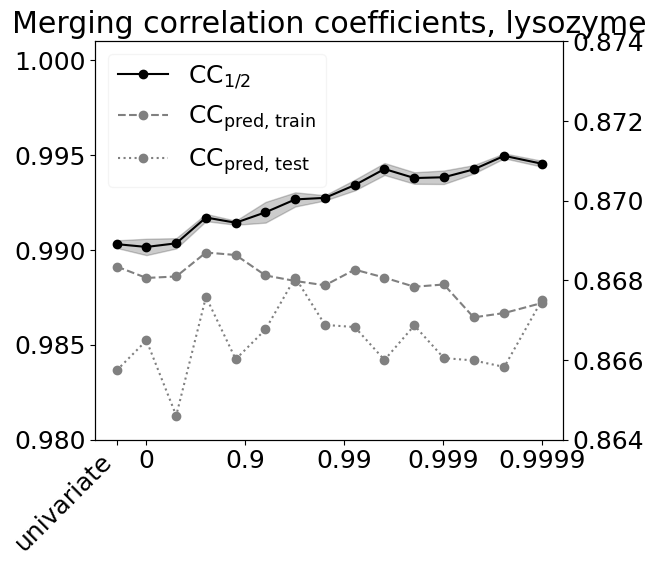

In [18]:
tmp=all_results.copy()
tmp=tmp.sort_values(by=["rDW"])

fig,ax = plt.subplots(figsize=(7,6))

lns1 = ax.plot(np.log10(1-tmp["rDW"]),tmp["CChalf"],'ko-',label=r"CC$_\text{1/2}$")
plt.fill_between(np.log10(1-tmp["rDW"]), tmp["CChalf"] - tmp["CChalf_std"], tmp["CChalf"] + tmp["CChalf_std"], color='k', alpha=0.2)

ax2 = ax.twinx()
lns2 = ax2.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_train"],'o--',color="gray",label=r"CC$_\text{pred, train}$")
lns3 = ax2.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_test"],'o:',color="gray",label=r"CC$_\text{pred, test}$")

plt.title("Merging correlation coefficients, lysozyme")
plt.xlabel("double-Wilson $r$")
#plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
ax.set_ylim([0.98,1.001])
ax2.set_ylim([0.864,0.874])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left',framealpha=0.2)

plt.tight_layout()
plt.savefig("CCs.svg",bbox_inches="tight")
plt.show()

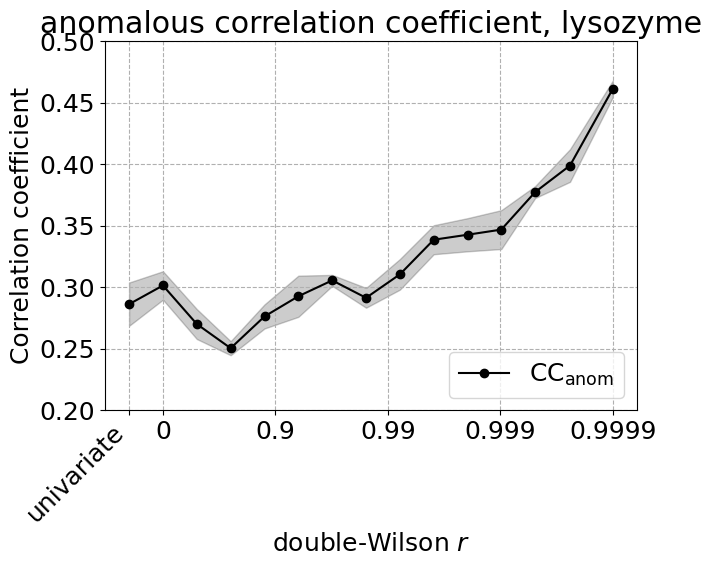

In [21]:
fig,ax = plt.subplots(figsize=(7,6))

plt.plot(np.log10(1-tmp["rDW"]),tmp["CCanom"],'ko-',label=r"CC$_\text{anom}$")
plt.fill_between(np.log10(1-tmp["rDW"]), tmp["CCanom"] - tmp["CCanom_std"], tmp["CCanom"] + tmp["CCanom_std"], color='k', alpha=0.2)

plt.grid(linestyle="--")
plt.title("anomalous correlation coefficient, lysozyme")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([0.2,0.5])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("CCanom.svg",bbox_inches="tight")
plt.show()

In [ ]:
all_results_peak_heights = all_results_peak_heights.sort_values(by="grid_id")
all_results_peak_heights.rename(columns={"grid_id":"rDW"}, inplace=True)
all_results_peak_heights.set_index("rDW", inplace=True)


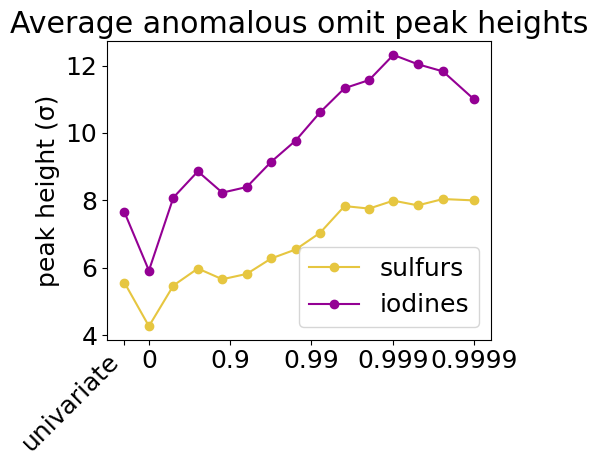

In [23]:
sulfur_atoms = []
iodine_atoms = []
for name in all_results_peak_heights.columns:
    if name[:3] == "IOD":
        iodine_atoms.append(name)
    else:
        sulfur_atoms.append(name)

iodines = all_results_peak_heights[iodine_atoms].mean(axis=1).to_numpy()
sulfurs = all_results_peak_heights[sulfur_atoms].mean(axis=1).to_numpy()

fig,ax = plt.subplots(figsize=[5.5,5])
plt.plot(np.log10(1-tmp["rDW"]),sulfurs,'o-',c=(0.9,0.775,0.25),label="sulfurs")
plt.plot(np.log10(1-tmp["rDW"]),iodines,'o-',c=(0.580392157,0.0,0.580392157),label="iodines")

plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.title("Average anomalous omit peak heights")
plt.ylabel("peak height (σ)")
plt.tight_layout()
plt.savefig("average_peak_heights.svg",bbox_inches="tight")
plt.show()

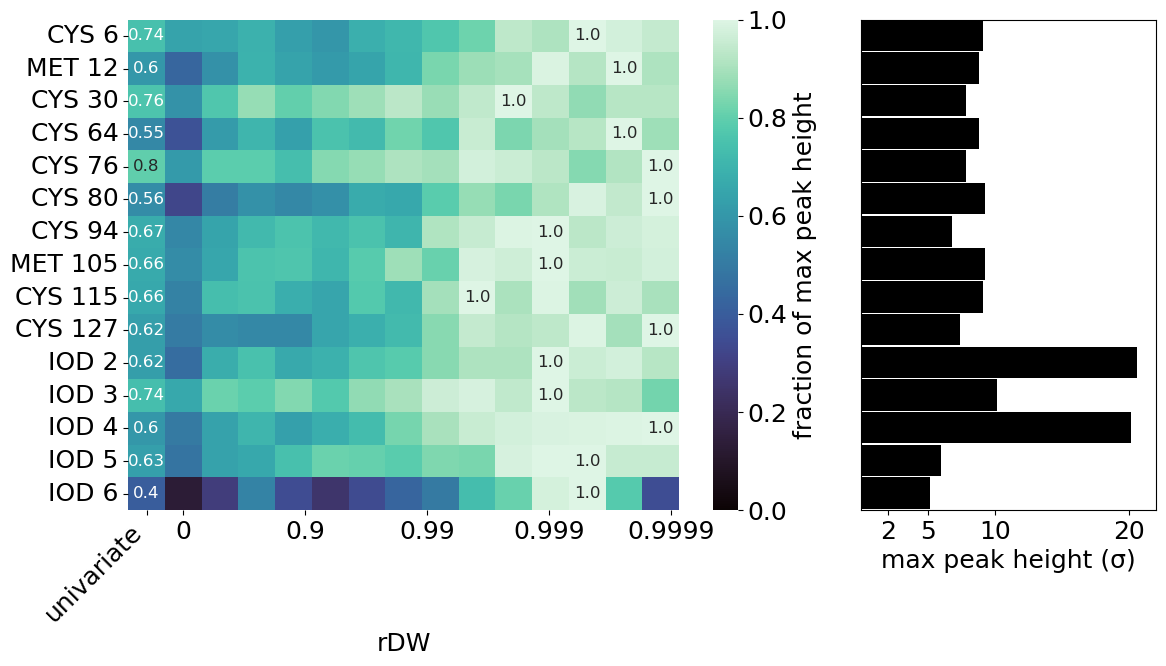

In [24]:
table = all_results_peak_heights.transpose()

max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')


def threshold(x):
    return '' if x<1 else np.round(x,1)
table_labels = table.applymap(threshold)
table_labels[-1] = np.round(table.iloc[:,0],2)

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="mako",
            cbar_kws={'label': 'fraction of max peak height'},
            annot=table_labels,
            annot_kws={"fontsize":12},
            fmt = '')


xticks = (1.5-np.log2(1-np.array([-1,0,0.9,0.99,0.999,0.9999])))
ax1.set_xticks(xticks)
ax1.set_xticklabels(["univariate","0","0.9","0.99","0.999","0.9999"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0,1) 

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.barh(table.index, max_table, color='k', height=0.96, align='edge')
ax2.tick_params(left=False, labelleft=False)
#ax2.set_xscale("log")
ax2.set_xlim([0,22])
ax2.set_xticks([2,5,10,20])
ax2.set_xticklabels([2,5,10,20])
ax2.set_xlabel('max peak height (σ)')
plt.tight_layout()
plt.savefig("peak_heights.svg",bbox_inches="tight")

In [58]:
%%bash 

mkdir ./pymol
cd pymol
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_R0.99902_0999_dmin1pt73/Refine_4/mlp32_PEF_R0.99902_0999_dmin1pt73_new_refine_2.pdb ./lysozyme_refine.pdb
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_Rneg1_0999_dmin1pt73/Refine_2/mlp32_PEF_Rneg1_0999_dmin1pt73_new_refine_2.mtz lysozyme_refine_univariate.mtz
cp -r ../careless_runs/phenix_poly_dw_mlp32_PEF_R0.99902_0999_dmin1pt73/Refine_2/mlp32_PEF_R0.99902_0999_dmin1pt73_new_refine_2.mtz ./lysozyme_refine_multivariate.mtz

mkdir: cannot create directory ‘./pymol’: File exists
